# 11장 심층 신경망 훈련하기

## 실용적인 가이드라인
- 커널 초기화: He 초기화
- 활성화 함수: ELU 혹은 빠른 속도의 ReLU
- 정규화: 얕은 신경망일 경우 벗음. 깊다면 Batch Normalization
- 규제: 조기 종료 (필요하면 l2 규제)
- 옵티마이저: Adam (또는 RMSProp이나 Nadam)
- LR 스케쥴: 1사이클

## 연습문제 8
CIFAR10 이미지 데이터셋에 심층 신경망을 훈련해보세요.

In [1]:
import sys
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

a.문제: 100개의 뉴런을 가진 은닉층 20개로 심층 신경망을 만들어보세요(너무 많은 것 같지만 이 연습문제의 핵심입니다). He 초기화와 ELU 활성화 함수를 사용하세요.

In [2]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

b.문제: Nadam 옵티마이저와 조기 종료를 사용하여 CIFAR10 데이터셋에 이 네트워크를 훈련하세요. keras.datasets.cifar10.load_ data()를 사용하여 데이터를 적재할 수 있습니다. 이 데이터셋은 10개의 클래스와 32×32 크기의 컬러 이미지 60,000개로 구성됩니다(50,000개는 훈련, 10,000개는 테스트). 따라서 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층이 필요합니다. 모델 구조와 하이퍼파라미터를 바꿀 때마다 적절한 학습률을 찾아야 한다는 것을 기억하세요.

출력층 추가

In [3]:
model.add(keras.layers.Dense(10, activation="softmax"))

In [4]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

C:\Users\anpdi\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


CIFAR10 데이터셋을 로드하죠. 조기 종료를 사용하기 때문에 검증 세트가 필요합니다. 원본 훈련 세트에서 처음 5,000개를 검증 세트로 사용하겠습니다:

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 29s 0us/step


In [6]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [8]:
%load_ext tensorboard

In [10]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 13s 7ms/step - loss: 4.0526 - accuracy: 0.1732 - val_loss: 2.1033 - val_accuracy: 0.2440
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 2.0263 - accuracy: 0.2588 - val_loss: 1.9987 - val_accuracy: 0.2574
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.9162 - accuracy: 0.2988 - val_loss: 2.0941 - val_accuracy: 0.2452
Epoch 4/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.8484 - accuracy: 0.3247 - val_loss: 1.9739 - val_accuracy: 0.3034
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7965 - accuracy: 0.3454 - val_loss: 1.7953 - val_accuracy: 0.3454
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.7432 - accuracy: 0.3687 - val_loss: 1.7447 - val_accuracy: 0.3640
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7041 - accuracy: 0.3830 - val_loss: 1.7180 - val_a

1407/1407 [==============================] - 9s 7ms/step - loss: 1.1138 - accuracy: 0.6020 - val_loss: 1.5707 - val_accuracy: 0.4700
Epoch 58/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.1111 - accuracy: 0.6036 - val_loss: 1.5477 - val_accuracy: 0.4706


In [11]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.5043 - accuracy: 0.4672


[1.5042527914047241, 0.46720001101493835]

c.문제: 배치 정규화를 추가하고 학습 곡선을 비교해보세요. 이전보다 빠르게 수렴하나요? 더 좋은 모델이 만들어지나요? 훈련 속도에는 어떤 영향을 미치나요?

- 출력층을 제외하고 모든 Dense 층 다음에 (활성화 함수 전에) BN 층을 추가했습니다. 처음 은닉층 전에도 BN 층을 추가했습니다.
- 학습률을 5e-4로 바꾸었습니다. 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3를 시도해 보고 20번 에포크 후에 검증 세트 성능이 가장 좋은 것을 선택했습니다.
- run_logdir를 runbn* 으로 이름을 바꾸고 모델 파일 이름을 my_cifar10_bn_model.h5로 변경했습니다.

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 30s 17ms/step - loss: 1.8440 - accuracy: 0.3392 - val_loss: 1.7015 - val_accuracy: 0.3874
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6689 - accuracy: 0.4068 - val_loss: 1.6215 - val_accuracy: 0.4134
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5991 - accuracy: 0.4308 - val_loss: 1.5559 - val_accuracy: 0.4470
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5487 - accuracy: 0.4485 - val_loss: 1.5148 - val_accuracy: 0.4586
Epoch 5/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5077 - accuracy: 0.4622 - val_loss: 1.4376 - val_accuracy: 0.4878
Epoch 6/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.4674 - accuracy: 0.4796 - val_loss: 1.4259 - val_accuracy: 0.4906
Epoch 7/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.4378 - accuracy: 0.4880 - val_loss: 1

[1.3221758604049683, 0.5353999733924866]

- 이전보다 빠르게 수렴하나요? 훨씬 빠릅니다! 이전 모델은 가장 낮은 검증 손실에 도달하기 위해 27 에포크가 걸렸지만 새 모델은 동일한 손실에 도달하는데 5 에포크가 걸렸고 16 에포크까지 계속 줄어듭니다. 이전 모델보다 두 배 이상 빠릅니다. BN 층은 훈련을 안정적으로 수행하고 더 큰 학습률을 사용할 수 있기 때문에 수렴이 빨라졌습니다.
- BN이 더 좋은 모델을 만드나요? 네! 최종 모델의 성능이 47.6%가 아니라 54.0% 정확도로 더 좋습니다. 이는 아주 좋은 모델이 아니지만 적어도 이전보다는 낫습니다(합성곱 신경망이 더 낫겠지만 이는 다른 주제입니다. 14장을 참고하세요).
- BN이 훈련 속도에 영향을 미치나요? 모델이 훨씬 빠르게 수렴했지만 각 에포크는 8초가 아니라 12초가 걸렸습니다. BN 층에서 추가된 계산 때문입니다. 하지만 전반적인 훈련 시간(탁상 시계 시간)은 크게 줄었습니다!

d.문제: 배치 정규화를 SELU로 바꾸어보세요. 네트워크가 자기 정규화하기 위해 필요한 변경 사항을 적용해보세요(즉, 입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층 신경망 등).

In [13]:
'''
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)
'''

'\nkeras.backend.clear_session()\ntf.random.set_seed(42)\nnp.random.seed(42)\n\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Flatten(input_shape=[32, 32, 3]))\nfor _ in range(20):\n    model.add(keras.layers.Dense(100,\n                                 kernel_initializer="lecun_normal",\n                                 activation="selu"))\nmodel.add(keras.layers.Dense(10, activation="softmax"))\n\noptimizer = keras.optimizers.Nadam(lr=7e-4)\nmodel.compile(loss="sparse_categorical_crossentropy",\n              optimizer=optimizer,\n              metrics=["accuracy"])\n\nearly_stopping_cb = keras.callbacks.EarlyStopping(patience=20)\nmodel_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)\nrun_index = 1 # 모델을 훈련할 때마다 증가시킴\nrun_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))\ntensorboard_cb = keras.callbacks.TensorBoard(run_logdir)\ncallbacks = [early_stopping_cb, model_checkpoint_cb, ten

In [14]:
#model = keras.models.load_model("my_cifar10_selu_model.h5")
#model.evaluate(X_valid_scaled, y_valid)

47.9% 정확도를 얻었습니다. 원래 모델(47.6%)보다 크게 높지 않습니다. 배치 정규화를 사용한 모델(54.0%)만큼 좋지도 않습니다. 하지만 BN 모델만큼 빠르게 수렴했습니다. 각 에포크는 7초만 걸렸습니다. 따라서 이 모델이 지금까지 가장 빠른 모델입니다.

e.문제: 알파 드롭아웃으로 모델에 규제를 적용해보세요. 그다음 모델을 다시 훈련하지 않고 MC 드롭아웃으로 더 높은 정확도를 얻을 수 있는지 확인해보세요.

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 17s 11ms/step - loss: 1.8898 - accuracy: 0.3311 - val_loss: 1.7277 - val_accuracy: 0.3878
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6642 - accuracy: 0.4141 - val_loss: 1.6905 - val_accuracy: 0.3818
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5691 - accuracy: 0.4506 - val_loss: 1.6987 - val_accuracy: 0.4296
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5048 - accuracy: 0.4692 - val_loss: 1.5738 - val_accuracy: 0.4618
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4495 - accuracy: 0.4944 - val_loss: 1.6148 - val_accuracy: 0.4488
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.4038 - accuracy: 0.5096 - val_loss: 1.5209 - val_accuracy: 0.4866
Epoch 7/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.3614 - accuracy: 0.5250 - val_loss: 1.5578 - v

[1.4750503301620483, 0.5062000155448914]

이 모델은 검증 세트에서 48.9% 정확도에 도달합니다. 드롭아웃이 없을 때보다(47.6%) 조금 더 좋습니다. 하이퍼파라미터 탐색을 좀 많이 수행해 보면 더 나아 질 수 있습니다(드롭아웃 비율 5%, 10%, 20%, 40%과 학습률 1e-4, 3e-4, 5e-4, 1e-3을 시도했습니다). 하지만 이 경우에는 크지 않을 것 같습니다.

이제 MC 드롭아웃을 사용해 보죠. 앞서 사용한 MCAlphaDropout 클래스를 복사해 사용하겠습니다:

In [16]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

방금 훈련했던 모델과 (같은 가중치를 가진) 동일한 새로운 모델을 만들어 보죠. 하지만 AlphaDropout 층 대신 MCAlphaDropout 드롭아웃 층을 사용합니다:

In [17]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

그다음 몇 가지 유틸리티 함수를 추가합니다. 첫 번째 함수는 모델을 여러 번 실행합니다(기본적으로 10번). 그다음 평균한 예측 클래스 확률을 반환합니다. 두 번째 함수는 이 평균 확률을 사용해 각 샘플의 클래스를 예측합니다:

In [18]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.506

이 경우에는 정확도 향상이 없습니다(여전히 정확도는 48.9%입니다).

따라서 이 연습문에서 얻은 최상의 모델은 배치 정규화 모델입니다.

f.문제: 1사이클 스케줄링으로 모델을 다시 훈련하고 훈련 속도와 모델 정확도가 향상되는지 확인해보세요.

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

#1사이클 스케쥴링

In [21]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 3s 7ms/step - loss: nan - accuracy: 0.1381


(9.999999747378752e-06,
 9.615227699279785,
 2.626567840576172,
 3.942450114658901)

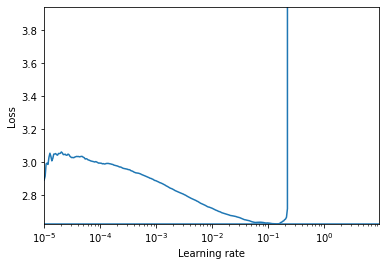

In [23]:
import math
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [24]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [26]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 8ms/step - loss: 2.0575 - accuracy: 0.2833 - val_loss: 1.7801 - val_accuracy: 0.3766
Epoch 2/15
352/352 [==============================] - 2s 7ms/step - loss: 1.7558 - accuracy: 0.3804 - val_loss: 1.6452 - val_accuracy: 0.4196
Epoch 3/15
352/352 [==============================] - 2s 7ms/step - loss: 1.6187 - accuracy: 0.4235 - val_loss: 1.6110 - val_accuracy: 0.4328
Epoch 4/15
352/352 [==============================] - 2s 7ms/step - loss: 1.5416 - accuracy: 0.4511 - val_loss: 1.6320 - val_accuracy: 0.4248
Epoch 5/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4885 - accuracy: 0.4716 - val_loss: 1.5921 - val_accuracy: 0.4574
Epoch 6/15
352/352 [==============================] - 2s 7ms/step - loss: 1.4458 - accuracy: 0.4878 - val_loss: 1.5663 - val_accuracy: 0.4612
Epoch 7/15
352/352 [==============================] - 3s 7ms/step - loss: 1.4067 - accuracy: 0.5027 - val_loss: 1.5254 - val_accuracy: 0.4644
Epoch 

1사이클 방식을 사용해 모델을 15에포크 동안 훈련했습니다. (큰 배치 크기 덕분에) 각 에포크는 2초만 걸렸습니다. 이는 지금까지 훈련한 가장 빠른 모델보다 몇 배 더 빠릅니다. 또한 모델 성능도 올라갔습니다(47.6%에서 52.0%). 배치 정규화 모델이 조금 더 성능(54%)이 높지만 훈련 속도가 더 느립니다